## Task 1 Inference


In [ ]:
from diffusers import DDPMScheduler, UNet2DModel, DDPMPipeline
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Load model
model = UNet2DModel.from_pretrained("models/T1-noisy/unet").to("cuda")

# Initialize noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
# generator=torch.manual_seed(1234)

  0%|          | 0/1000 [00:00<?, ?it/s]

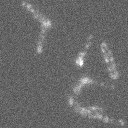

In [ ]:
pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)
pipe(batch_size=16).images[0]

## Task 2 Inference

In [4]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
import torch

# Change the following line to test different models
controlnet_path = "models/T2-noisy/checkpoint-10000/controlnet"  

base_model_path = "benjamin-paine/stable-diffusion-v1-5"  # Do not change this line
controlnet = ControlNetModel.from_pretrained(controlnet_path, torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path, controlnet=controlnet, torch_dtype=torch.float16, safety_checker=None # safety_checker messes with mito
).to("cuda")

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/suyog/anaconda3/envs/cellstory/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/home/suyog/anaconda3/envs/cellstory/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or ap

  0%|          | 0/500 [00:00<?, ?it/s]

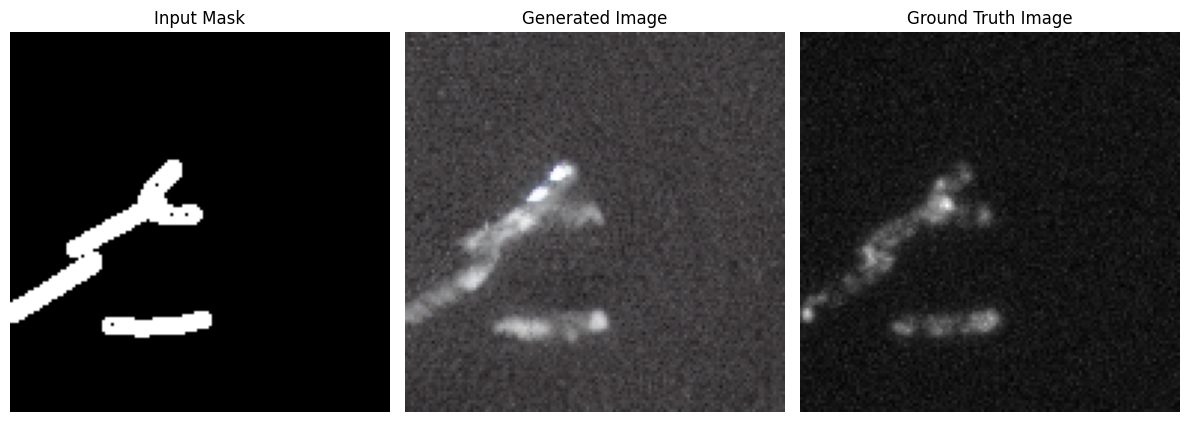

In [20]:
import random, os
import matplotlib.pyplot as plt
i = str(random.randint(8000, 9999)).zfill(4)  # random image from validation set
control_image = load_image(f"../data_experiments/data/mito_variable_sbrs_big_80nm/segmask_semantic/mito_{i}.png")
gt_image = load_image(f"../data_experiments/data/mito_variable_sbrs_big_80nm/xy_max_uint8/mito_{i}.tif")
prompt = "Fluorescence microscopy image of mitochondria against a noisy background"

# generate image
generator = torch.manual_seed(0)
image = pipe(
    prompt, num_inference_steps=500, generator=generator, image=control_image
).images[0]

# plot and save png
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(control_image)
plt.axis("off")
plt.title("Input Mask")
plt.subplot(1, 3, 2)
plt.imshow(image)
plt.axis("off")
plt.title("Generated Image")
plt.subplot(1, 3, 3)
plt.imshow(gt_image)
plt.axis("off")
plt.title("Ground Truth Image")
plt.tight_layout()
plt.show()
# os.makedirs(os.path.join("results", *controlnet_path.split("/")[:2]), exist_ok=True)